In [1]:
%reset -sf

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import os
import math

C:\Users\Reza\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.reset_default_graph()

In [4]:
#inputs
path_img="C:/Users/Reza/Desktop/Deep learning/project/u-net segmentation/Image-Segmentation-with-Tensorflow-master/Carvana Image Masking Challenge (kaggle)/train/"
path_mask="C:/Users/Reza/Desktop/Deep learning/project/u-net segmentation/Image-Segmentation-with-Tensorflow-master/Carvana Image Masking Challenge (kaggle)/train_masks/"
batch_size=32
img_size=128
en_cov_size=4
de_cov_size=3
gen_filter=64
dic_filter=64
learning_rate=0.0001
epochs=2
restore=True

In [5]:
#load-shuffel images

names=list(map(lambda x:x.split(".")[0],os.listdir(path_img)))

np.random.shuffle(names)

def load_img(batch_num):
    
    imgs=[]
    masks=[]
    for i in names[batch_num*batch_size:(batch_num+1)*batch_size]:
        img=cv2.imread(path_img+i+".jpg",0)
        img=cv2.resize(img,(img_size,img_size),interpolation = cv2.INTER_CUBIC)
        img=np.expand_dims(img,2)
        imgs.append(img/255.)
        
        mask=Image.open(path_mask+i+"_mask.gif")
        mask=np.array(mask.resize([img_size,img_size]))
        mask=np.expand_dims(mask,2)
        masks.append(mask/1.)
        
    return np.array(imgs),np.array(masks)


In [6]:
input_img=tf.placeholder(dtype=tf.float32,shape=(None,img_size,img_size,1))
input_mask=tf.placeholder(dtype=tf.float32,shape=(None,img_size,img_size,1))
trains= tf.placeholder_with_default(True,shape=())

In [7]:
def lrelu(x):
    return tf.maximum(0.2*x,x)

In [8]:
def conv2d(input_,filter_,size,stride_,layer_num,train=True):
    L1=tf.layers.conv2d(inputs=input_,filters=filter_,kernel_size=size,strides=stride_,padding="same",
                        kernel_initializer=tf.keras.initializers.he_uniform())
    
    if(layer_num>0):
        L1=tf.layers.batch_normalization(inputs=L1,training=train)
        L1=tf.nn.leaky_relu(L1)
    elif(layer_num==-1):
        L1=tf.nn.leaky_relu(L1)
    return L1

In [9]:
def deconc2d(input_,filter_,size,stride_,layer_num,train=True):
    
    #L1=tf.layers.conv2d_transpose(inputs=input_,filters=filter_,kernel_size=4,strides=2,padding="same")
    
    L1=tf.keras.layers.UpSampling2D(2)(input_)
    
    L1=conv2d(L1,filter_,size,1,2,train)
    
    if(layer_num>0):
        L1=tf.layers.batch_normalization(inputs=L1,training=train)
        L1=tf.nn.relu(L1)
    
    return L1

In [10]:
def layers(input_,filter_,layer_num,train=True):
    current=conv2d(input_,filter_,4,2,layer_num,train)
    #print("L1:",layer_num,current)
    if(layer_num<3):
        current=layers(current,filter_*2,(layer_num+1),train=train)
        #print("current:",layer_num,current)
    L2=deconc2d(current,filter_//2,3,2,layer_num,train=train)
    #print("L2:",layer_num,L2)
    output=tf.concat([L2,input_],axis=3)
    #print("out:",layer_num,output)
    return output

In [11]:
def gen(input_,train=True,reuse=False):
    #print(train)
    with tf.variable_scope("generator", reuse=reuse):
        L0=conv2d(input_,gen_filter,en_cov_size,2,0,train)
        gen_mask=layers(L0,128,1,train=train)
        gen_mask=tf.concat([L0,gen_mask],axis=3)
        out=deconc2d(gen_mask,1,de_cov_size,2,0,train)
    if(train==False):     
        return tf.nn.sigmoid(out)
    else:
        return out

In [12]:
def disc(input_,train,reuse=False):
    
    with tf.variable_scope("disc", reuse=reuse):
        #print(input_.get_shape())
        loss1=conv2d(input_,dic_filter,4,2,-1,train=train)
        loss2=conv2d(loss1,dic_filter*2,4,2,1,train=train)
        loss3=conv2d(loss2,dic_filter*4,4,2,1,train=train)

    
    loss=tf.concat([tf.layers.flatten(input_),tf.layers.flatten(loss1),tf.layers.flatten(loss2),
                    tf.layers.flatten(loss3)],axis=1)
    return loss

In [13]:
def dice_loss(input_, target):
    smooth = 0.1

    iflat = tf.layers.flatten(input_)
    tflat = tf.layers.flatten(target)
    intersection = tf.reduce_sum(iflat * tflat)
    
    return 1. - ((2. * intersection + smooth) /
              (tf.reduce_sum(iflat) + tf.reduce_sum(tflat) + smooth))

In [14]:
def dcgans(input_,input_mask,train,reuses=False):
    
    fake_mask=gen(input_,train=train,reuse=reuses)
    #print(fake_mask.get_shape())
    fake_mask=tf.multiply(input_,tf.nn.sigmoid(fake_mask))
    #print(fake_mask.get_shape())
    fake_loss=disc(fake_mask,train=train,reuse=reuses)
    real_mask=tf.multiply(input_mask,input_)
    #print(real_mask.get_shape())
    real_loss=disc(real_mask,train=train,reuse=True)
    
    loss_D=-tf.reduce_mean(tf.abs(fake_loss-real_loss))
    
    
    loss_dice= dice_loss(fake_mask,real_mask)
    loss_G= tf.reduce_mean(tf.abs(fake_loss-real_loss))
    loss_G_joint= loss_dice+loss_G
    
    
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith("disc")]
    g_vars=[var for var in t_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_G_joint,var_list=g_vars)
        d_train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_D,var_list=d_vars)
        
    clip_op = [p.assign(tf.clip_by_value(p, -0.05, 0.05)) for p in d_vars]
    
    return g_train,d_train,loss_G_joint,loss_D,clip_op


In [15]:
g_train,d_train,g_loss,d_loss_sum,clip_op=dcgans(input_img,input_mask,train=trains,reuses=False)

In [16]:
saver = tf.train.Saver()

sess=tf.Session()

if (restore==True):
    saver.restore(sess, "./model-50")
    print("Model restored.")
else:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

INFO:tensorflow:Restoring parameters from ./model-50
Model restored.


In [17]:
for epoch in range(epochs):
    np.random.shuffle(names)
    for i in range(len(names)//batch_size):
        img_batch,mask_batch=load_img(i)
        
        _,dloss,_=sess.run([d_train,d_loss_sum,clip_op],feed_dict={input_img:img_batch,input_mask:mask_batch,trains:True})
        _,gloss=sess.run([g_train,g_loss],feed_dict={input_img:img_batch,input_mask:mask_batch,trains:True})
        
        if(i%50==0):
            save_path = saver.save(sess, "./model",global_step=i)
            print("Model saved in path: %s" % save_path)
            a=sess.run(gen(input_img,train=False,reuse=True),feed_dict={input_img:img_batch,input_mask:mask_batch,trains:False})
            a[a<.5]=0.
            a[a>.5]=1.
            cv2.imwrite("C:/Users/Reza/Desktop/Deep learning/project/DeepLearning-SeGAN-Segmentation-master/"+str(i)+".png",a[0,...]*255.)
            cv2.imwrite("C:/Users/Reza/Desktop/Deep learning/project/DeepLearning-SeGAN-Segmentation-master/"+str(i)+"_mask.png",mask_batch[0,...]*255.)
            print("gloss:{},dloss:{}".format(gloss,dloss))

In [18]:
path_img="C:/Users/Reza/Desktop/Deep learning/project/u-net segmentation/Image-Segmentation-with-Tensorflow-master/Carvana Image Masking Challenge (kaggle)/test/"

#load-shuffel images

names=list(map(lambda x:x.split(".")[0],os.listdir(path_img)))

np.random.shuffle(names)

def load_test_img(batch_num):
    
    imgs=[]
    masks=[]
    for i in names[batch_num*batch_size:(batch_num+1)*batch_size]:
        img=cv2.imread(path_img+i+".jpg",0)
        img=cv2.resize(img,(img_size,img_size),interpolation = cv2.INTER_CUBIC)
        img=np.expand_dims(img,2)
        imgs.append(img/255.)
        
    return np.array(imgs)


In [22]:
img_batch=load_test_img(0)
a=sess.run(gen(input_img,train=False,reuse=True),feed_dict={input_img:img_batch,trains:False})
#a=img_batch*a

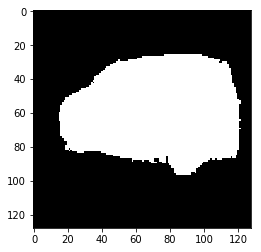

In [29]:
a[a<.5]=0.
a[a>.5]=1.
plt.imshow(a[0,...,0],cmap="gray")

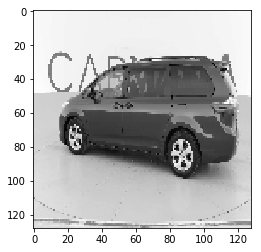

In [30]:
plt.imshow(img_batch[0,...,0],cmap="gray")

In [ ]:
plt.imshow(mask_batch[2,...,0],cmap="gray")

In [ ]:
sess.close()